In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [2]:
# read the csv files & print shape, columns
df = pd.read_csv('Data Analyst - Test Data.csv')
df.shape, df.columns

((5618, 4), Index(['Review', 'date', 'Author', 'Location'], dtype='object'))

- No.of rows, cols = (5618, 4)
- Columns = Review, Date, Author, Location
- Looks like data is collected from social site where people post reviews about the places they visited.

### Univariate Analysis on each column

In [3]:
df.apply(lambda x: len(x.unique()))

Review      5607
date         344
Author      3973
Location    1329
dtype: int64

- num of unique dates = 344, seems data belongs to time period of 1 year.
- num of unique authors = 3973, Few authors posted more than 1 review.
- num of unique locations = 1329, Authors belongs to\ reviews were posted from 1329 different locations.

In [4]:
df.isnull().sum()

Review         0
date           0
Author         0
Location    1012
dtype: int64

In [5]:
# df[df['Location'].isnull()]
df['Location'] = df['Location'].fillna('Unknown, Unknown')
df['Location'].min(), df['Location'].max()

('09/09/2017', 'Стокгольм')

In [6]:
sorted(df['Location'])[:5], sorted(df['Location'])[-5:], 

(['09/09/2017',
  '1114 Budapest',
  'Aachen, Germany',
  'Aalborg, Denmark',
  'Aarhus, Denmark'],
 ['wallington,surrey',
  'wallington,surrey',
  'Ås, Akershus, Norway',
  'Одесса, Украина',
  'Стокгольм'])

- There are 1012 unkonwn locations, I filled them with None for further analysis
- Further there are few abbrevations used in the locations (like UK for united kingdom)
- There is one date value in location column...An Entry Error.
- There are 3 locations with unicode text in language other than English.

In [7]:
df['Location'].value_counts().head(5)

Unknown, Unknown          1012
London, United Kingdom     251
Colombo, Sri Lanka         198
Melbourne, Australia       127
Sydney, Australia          114
Name: Location, dtype: int64

In [8]:
df['date'].min(), df['date'].max()

('2018/05/02', '2019/04/16')

In [9]:
df['date'].value_counts().head(5)

2019/04/16    150
2019/01/16     40
2018/08/27     39
2019/01/20     38
2019/01/21     38
Name: date, dtype: int64

- Most reviews posted from the same Location is 251 from London, UK. (excluding the unknown values).
- The reviews are collected over time range of (May 2018 to April 2019)...i.e for period of 12 months.
- Highest reviews on single day is 150, posted on 16/04/2019.

In [10]:
df['Author'].value_counts().head()

Umang A          12
sherry_dissa     11
roamingkiwi24     9
Ruth C            9
worldnomad_01     8
Name: Author, dtype: int64

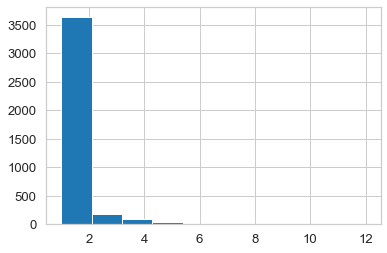

In [11]:
df['Author'].value_counts().hist()

- Maximum num of reviews from a single author = 12...this could be review of 12 places he visited. There also chance these coul be baised\fake reviews, as mostly (~90%) authors are having only one or < less than 2 reviews.

### Vocabulary Analysis of 'Review' column

In [12]:
df['num_words'] = df['Review'].apply(lambda x: len(str(x).split(" ")))
df['num_chars'] = df['Review'].str.len() ## this also includes spaces
print('Average words in a review:', df['num_words'].mean())
print('Average characters in a review:', df['num_chars'].mean())

Average words in a review: 68.57796368814525
Average characters in a review: 370.1699893200427


In [13]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
df['num_stops'] = df['Review'].apply(lambda x: len([x for x in x.split() if x in stopwords]))
print('Average num of stop words in a review:', df['num_stops'].mean())

Average num of stop words in a review: 29.172125311498753


- Interestingly...40% (approx) of review words are stopwords.

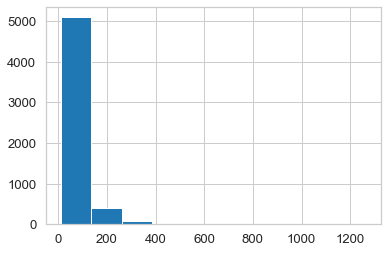

In [14]:
df['num_words'].hist()

- Around 5000 reviews contains words in range 0 to 100.
- Around 400 reviews contains words in range 100 to 200.
- remaning reviews contains words > 200.

In [15]:
from nltk.tokenize import sent_tokenize, word_tokenize

import string  
puncts = string.punctuation  

tokens = []
for review in df['Review']:
    words = [x for x in word_tokenize(review) if x not in stopwords]
    words = [x.lower() for x in words if len(x) >= 3 and x not in puncts]
    tokens.extend(words)
len(tokens)

203157

In [16]:
from nltk.probability import FreqDist
fdist = FreqDist(tokens)
print(fdist)  # there are around 16K unique vocabulary\english words.

<FreqDist with 16214 samples and 203157 outcomes>


In [17]:
fdist.most_common(5)

[('the', 2849),
 ('place', 1756),
 ('temple', 1699),
 ('see', 1669),
 ('visit', 1509)]

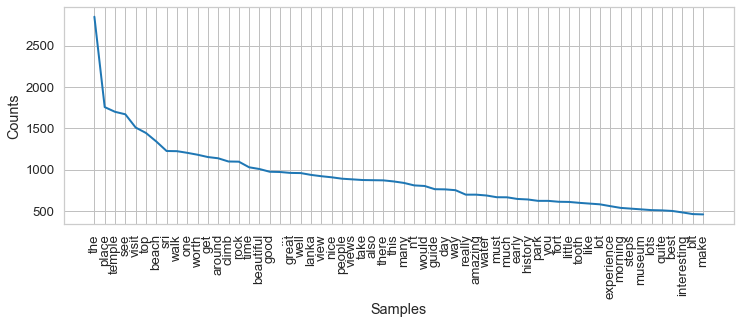

In [18]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
fdist.plot(60,cumulative=False)
plt.show()

- There were around 1000 occurences of sri-lanka...indicating reviews are mostly pertaining to tour of sri-lanka
- mostly +ve words like beautiful, good,nice, worth, amazing, best...indicating most people are having +ve experience.
- Other words like temple, beach rock, climb, fort, museum...indicate the most popular visited by tourists.

### Sentiment Analysis

In [19]:
from textblob import TextBlob

reviews_clean = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
reviews_clean = reviews_clean.str.replace('[^\w\s]','')

# extract polarity which will in range [-1, 1] --> [negative, positive]
df['sentiment_score'] = reviews_clean.apply(lambda x: TextBlob(x).sentiment[0])

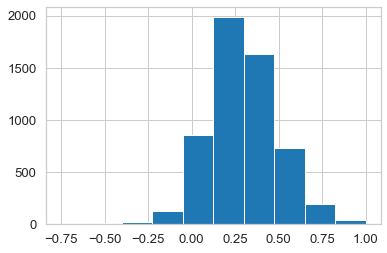

In [20]:
df['sentiment_score'].hist()

In [21]:
df['sentiment'] = 0
df.loc[df['sentiment_score'] >  0.25, 'sentiment'] = 1
df.loc[df['sentiment_score'] < -0.10, 'sentiment'] = -1

In [22]:
df['sentiment'] = df['sentiment'].replace({0:'neutral', 1:'positive', -1:'negative'})
df['sentiment'].value_counts(normalize = 1)

positive    0.561054
neutral     0.421146
negative    0.017800
Name: sentiment, dtype: float64

- around 56% vistors are +ve, 42% are neutral & 1.78% are -ve about their vists to srilanka. (These are based on the manual threshold according to my knowledge.)

In [23]:
pos_df = df[df['sentiment'] == 'positive']
neu_df = df[df['sentiment'] == 'neutral']
neg_df = df[df['sentiment'] == 'negative']

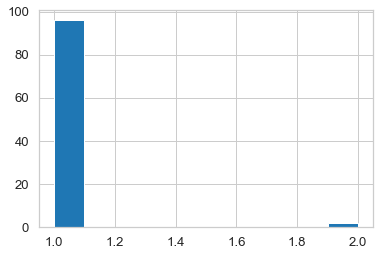

In [24]:
neg_df['Author'].value_counts().hist()

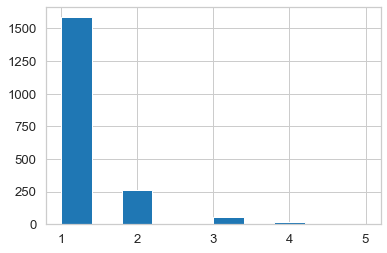

In [25]:
neu_df['Author'].value_counts().hist()

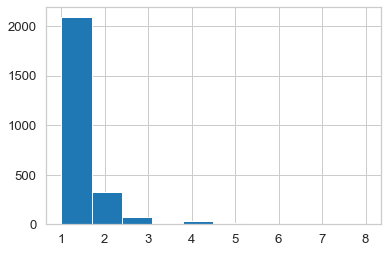

In [26]:
pos_df['Author'].value_counts().hist()